In [0]:
#pip install pandas numpy seaborn matplotlib scikit-learn scipy xgboost yellowbrick scikit-optimize imblearn optuna mlflow


Python interpreter will be restarted.
  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl (297.1 MB)
  Using cached scikit_optimize-0.10.1-py2.py3-none-any.whl (107 kB)
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
  Using cached optuna-3.6.1-py3-none-any.whl (380 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Not uninstalling markupsafe at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-b860c711-ad3c-4fa7-a9ef-b7b1b9883c6a
    Can't uninstall 'MarkupSafe'. No files were found to uninstall.
  Attempting uninstall: Jinja2
    Found existing installation: Jinja2 2.11.3
    Not uninstalling jinja2 at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-b860c711-ad3c-4fa7-a9ef-b7b1b9883c6a
    Can't uninstall 'Jinja2'. No files were found to uninstall.
  Attempting uninstall: click
    Found existing 

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import  precision_recall_curve, average_precision_score,f1_score, recall_score, precision_score,fbeta_score,make_scorer
from sklearn.metrics import roc_curve, roc_auc_score, ConfusionMatrixDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.feature_selection import RFE

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
import xgboost
from sklearn.ensemble import RandomForestClassifier, IsolationForest, StackingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import ClassPredictionError


In [0]:
file_location = "/FileStore/tables/train_df-3.csv"
dbutils.fs.cp("/FileStore/tables/train_df-3.csv", "file:///tmp/train_df-3.csv") 

# Read the CSV into a pandas DataFrame 
df = pd.read_csv("file:///tmp/train_df-3.csv")

In [0]:
file_location = "/FileStore/tables/test_df-3.csv"
dbutils.fs.cp("/FileStore/tables/test_df-3.csv", "file:///tmp/test_df-3.csv") 

# Read the CSV into a pandas DataFrame 
test_df = pd.read_csv("file:///tmp/test_df-3.csv")


In [0]:
def preprocess_data(df, country_categories, pca_model=None, kmeans_model=None, fit_pca=True, fit_kmeans=True):
    # Validate presence of 'fullVisitorId'
    if 'fullVisitorId' not in df.columns:
        raise KeyError("DataFrame must include 'fullVisitorId' column.")

    # Calculate User Engagement Depth
    df['UserEngagementDepth'] = df['TotalPageviews'] / df['TotalVisits']
    df['UserEngagementDepth'].replace([float('inf'), -float('inf'), float('nan')], 0, inplace=True)
    
    # Standardize select features for clustering to improve performance
    features_for_clustering = ['TotalPageviews', 'TotalVisits', 'UserEngagementDepth', 'desktop', 'mobile', 'tablet']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(df[features_for_clustering])
    
    # Perform clustering
    if fit_kmeans:
        kmeans_model = KMeans(n_clusters=6, random_state=42)
        clusters = kmeans_model.fit_predict(scaled_features)
    else:
        clusters = kmeans_model.predict(scaled_features)
    df['ClusterLabel'] = clusters
    # One-hot encode the cluster labels if necessary
    cluster_dummies = pd.get_dummies(df['ClusterLabel'], prefix='Cluster', dtype='int64',drop_first=True)
    df = pd.concat([df, cluster_dummies], axis=1)
    df.drop('ClusterLabel', axis=1, inplace=True)

    
    # One-hot encode 'country' and reindex with all possible categories to ensure consistency
    country_encoded = pd.get_dummies(df['country'], prefix='country')
    country_encoded = country_encoded.reindex(columns=['country_' + c for c in country_categories], fill_value=0)
    
    if fit_pca:
        pca_model = PCA(n_components=3)
        country_pca = pca_model.fit_transform(country_encoded)
    else:
        country_pca = pca_model.transform(country_encoded)
    
    country_pca_df = pd.DataFrame(country_pca, columns=['country_PC1', 'country_PC2', 'country_PC3'])
    
    # Merge PCA data back, ensure 'fullVisitorId' is available for any needed operations
    country_pca_df['fullVisitorId'] = df['fullVisitorId'].values
    df = pd.merge(df, country_pca_df, on='fullVisitorId', how='inner')

    df.drop(['fullVisitorId', 'country', 'TotalVisits', 'LastSessionPageviews', 'TotalPageviews'], axis=1, inplace=True)
    
    # Handle other categorical columns
    cat_cols = df.select_dtypes(include='object').columns
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True, dtype='int64')
    
    X = df.drop('at_least_one_conversion', axis=1)
    y = df['at_least_one_conversion']
    
    return X, y, pca_model, kmeans_model

In [0]:
df_train, df_val = train_test_split(df, test_size=0.15, random_state=42, stratify=df['at_least_one_conversion'])


In [0]:
df.dtypes

Out[24]: fullVisitorId               object
FirstChannelVisit           object
LastChannelVisit            object
at_least_one_conversion      int64
country                     object
continent                   object
subContinent                object
TotalVisits                  int64
TotalBounces                 int64
Organic Search               int64
Social                       int64
Direct                       int64
Paid Search                  int64
Referral                     int64
Affiliates                   int64
Display                      int64
(Other)                      int64
TotalPageviews               int64
desktop                      int64
mobile                       int64
tablet                       int64
FirstSessionPageviews        int64
LastSessionPageviews         int64
CampaignVisits               int64
isTrueDirect                 int64
AdContentVisits              int64
Source_PC1                 float64
Source_PC2                 float64
Source_PC3 

In [0]:
country_categories = df['country'].unique().tolist()

In [0]:
# Fit the models initially
X_train, y_train, pca_train, kmeans_train = preprocess_data(df_train, country_categories, fit_pca=True, fit_kmeans=True)

# Preprocess the validation data using the existing PCA and KMeans models
X_val, y_val, _, _ = preprocess_data(df_val, country_categories, pca_model=pca_train, kmeans_model=kmeans_train, fit_pca=False, fit_kmeans=False)
X_test, y_test, _, _ = preprocess_data(test_df, country_categories, pca_model=pca_train, kmeans_model=kmeans_train, fit_pca=False, fit_kmeans=False)

In [0]:
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def plot_pr_curve(precision, recall, average_precision):
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

from matplotlib.colors import ListedColormap
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        predictions_train = clf.predict(X_train)
        print("Train Result:\n")
        print(f"accuracy score: {accuracy_score(y_train, predictions_train):.4f}\n")
        print(f"Classification Report: \n {classification_report(y_train, predictions_train)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, predictions_train)}\n")

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print(f"Average Accuracy: \t {np.mean(res):.4f}")
        print(f"Accuracy SD: \t\t {np.std(res):.4f}")

    else:
        predictions_val = clf.predict(X_val)
        probas_val = clf.predict_proba(X_val)[:, 1]  
        precision, recall, _ = precision_recall_curve(y_val, probas_val)
        average_precision = average_precision_score(y_val, probas_val)
        plot_pr_curve(precision, recall, average_precision)

        fpr, tpr, _ = roc_curve(y_val, probas_val)
        roc_auc = roc_auc_score(y_val, probas_val)
        print(f"roc auc score: {roc_auc}\n")
        plot_roc_curve(fpr, tpr, roc_auc)

        print(f"Classification Report: \n {classification_report(y_val, predictions_val)}\n")
        print(f"Confusion Matrix: \n {confusion_matrix(y_val, predictions_val)}\n")
        ConfusionMatrixDisplay.from_estimator(clf, X_val, y_val).im_.set_cmap(ListedColormap(['#34a853', '#4285f4', '#fbbb07']))
        plt.show()
        print("End of validation Result\n")


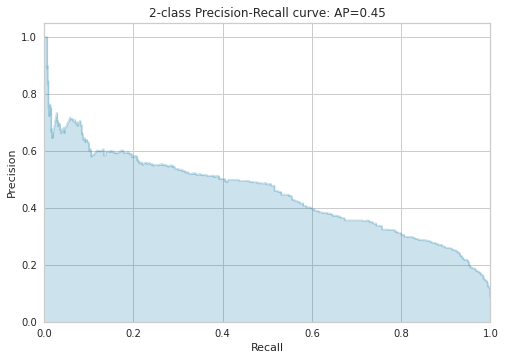

roc auc score: 0.9860656269345422



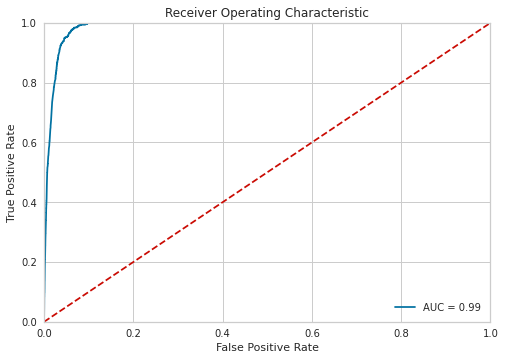

Classification Report: 
               precision    recall  f1-score   support

           0       1.00      0.93      0.96     84092
           1       0.15      0.98      0.27      1114

    accuracy                           0.93     85206
   macro avg       0.58      0.96      0.62     85206
weighted avg       0.99      0.93      0.95     85206


Confusion Matrix: 
 [[78103  5989]
 [   17  1097]]



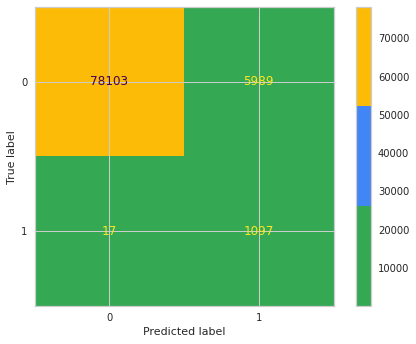

End of validation Result



In [0]:
rf_model=RandomForestClassifier(n_estimators=100,max_depth=5, random_state=42, class_weight='balanced')
rf_model.fit(X_train, y_train)
clf_score(rf_model, X_train, y_train, X_val, y_val, train=False)

In [0]:
# getting the feature importance from the random forest model   
feature_importances = pd.DataFrame(rf_model.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
# Using the top 20 features from the random forest model
top_features = feature_importances.index[:20]
X_train = X_train[top_features]
X_val = X_val[top_features]
X_test = X_test[top_features]


In [0]:
# 1. Apply undersampling to the training set
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=42)  # Set random_state for reproducibility
X_train, y_train = rus.fit_resample(X_train, y_train)

In [0]:
import mlflow
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
import optuna
import json 

# Set the experiment name correctly
mlflow.set_experiment('/Users/tashfeenahmad12@gmail.com/classification')
def objective(trial):
    # Define hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.2),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'gamma': trial.suggest_loguniform('gamma', 0.1, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0)
    }
    threshold = trial.suggest_uniform('threshold', 0.1, 0.9)

    model = xgb.XGBClassifier(**params, use_label_encoder=False, eval_metric='logloss', random_state=42)
    model.fit(X_train, y_train)
    probabilities = model.predict_proba(X_val)[:, 1]
    predictions = (probabilities >= threshold).astype(int)
    f1_score_val = f1_score(y_val, predictions)

    return f1_score_val

def log_best_model(trial, model):
    with mlflow.start_run(run_name="XGBoost Model with threshold"):
        mlflow.log_params(trial.params)
        # 1. Dataset Metadata (Illustrative example)
        dataset_metadata = {
            'source': 'https://www.kaggle.com/competitions/ga-customer-revenue-prediction/data?select=train_v2.csv',
            'features': list(X_train.columns), 
            'preprocessing': 'Scaling, one-hot encoding, SMOTEENN', 
            'target_variable': 'at_least_one_conversion'
        }
        mlflow.log_text(json.dumps(dataset_metadata), "dataset_metadata.json") 

        # 2. Save and log model
        mlflow.xgboost.log_model(model, "xgboost_model")
        
        # Evaluate and log metrics on train, validation, and test sets
        evaluate_and_log_metrics(model, trial.params['threshold'])

def evaluate_and_log_metrics(model, threshold):
    datasets = {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}
    for key, (X, y) in datasets.items():
        probs = model.predict_proba(X)[:, 1]
        predictions = (probs >= threshold).astype(int)
        metrics = {
            f'{key}_accuracy': accuracy_score(y, predictions),
            f'{key}_precision': precision_score(y, predictions),
            f'{key}_recall': recall_score(y, predictions),
            f'{key}_f1': f1_score(y, predictions),
            f'{key}_roc_auc': roc_auc_score(y, probs)
        }
        mlflow.log_metrics(metrics)

# Create and optimize an Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

best_trial = study.best_trial
best_model = xgb.XGBClassifier(**{k: v for k, v in best_trial.params.items() if k != 'threshold'}, use_label_encoder=False, eval_metric='logloss', random_state=42)
best_model.fit(X_train, y_train)
log_best_model(best_trial, best_model)


[I 2024-04-25 02:24:18,258] A new study created in memory with name: no-name-139b24b3-c03e-49b8-a9c3-092a7f72145a
[I 2024-04-25 02:24:24,618] Trial 0 finished with value: 0.34929850024189646 and parameters: {'n_estimators': 1541, 'max_depth': 9, 'learning_rate': 0.01299799673428035, 'subsample': 0.8813464067112278, 'colsample_bytree': 0.8607594373937371, 'min_child_weight': 2, 'gamma': 0.5205195481981983, 'reg_lambda': 8.94954010183955e-06, 'reg_alpha': 5.31598473042347e-06, 'threshold': 0.6774163519805237}. Best is trial 0 with value: 0.34929850024189646.
[I 2024-04-25 02:24:26,736] Trial 1 finished with value: 0.20946529711049247 and parameters: {'n_estimators': 1621, 'max_depth': 10, 'learning_rate': 0.013323313987105321, 'subsample': 0.5025763242986288, 'colsample_bytree': 0.7605127736997741, 'min_child_weight': 249, 'gamma': 0.21472904165825096, 'reg_lambda': 0.06699547045011353, 'reg_alpha': 5.784730359520172e-06, 'threshold': 0.39421535334727253}. Best is trial 0 with value: 0.3

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
import mlflow
logged_model = 'runs:/c82ac616b1134cd98adf48576111ce39/xgboost_model'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

# Predict on a Pandas DataFrame.
import pandas as pd
loaded_predictions=loaded_model.predict(X_test)

In [0]:
f1_score(y_test,loaded_predictions)

Out[100]: 0.36443867618429593

In [0]:
type(X_test)

Out[103]: pandas.core.frame.DataFrame

In [0]:
loaded_predictions_df = pd.DataFrame(loaded_predictions,columns = ["predictions"])

X_test_spark = pd.concat([X_test, loaded_predictions_df,y_test], axis=1)


In [0]:
X_test_spark.head(1)

,UserEngagementDepth,country_PC1,Cluster_5,FirstSessionPageviews,country_PC2,desktop,continent_Americas,isTrueDirect,country_PC3,subContinent_Northern America,...,FirstChannelVisit_Social,Cluster_1,Referral,Source_PC1,LastChannelVisit_Social,LastChannelVisit_Referral,TotalBounces,Organic Search,predictions,at_least_one_conversion
0,2.0,-0.372973,0,2,-0.20258,1,0,0,0.76974,0,...,0,0,0,0.569687,0,0,0,1,0,0


In [0]:
X_test_spark = spark.createDataFrame(X_test_spark)
X_test_spark = X_test_spark.limit(15)



In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import monotonically_increasing_id, to_json, struct, col

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("KafkaDataWrite") \
    .getOrCreate()

# Assume X_test_spark is already loaded as a Spark DataFrame
X_test_spark = X_test_spark.withColumn("key", monotonically_increasing_id())
X_test_spark = X_test_spark.withColumn("value", to_json(struct([col(c) for c in X_test_spark.columns if c != 'key'])))

# Prepare data for Kafka
kafka_ready_df = X_test_spark.selectExpr("CAST(key AS STRING) AS key", "CAST(value AS STRING) AS value")

# Write to Kafka
api_key = "AO355DNAQ4YOSZUR"
api_secret = "Jts1hjQ91q1wes/lo6AN/J4sRorMMvebAxTM7Oo37IkPOin3F55AHUwZhOE02693"
bootstrap_servers = "pkc-56d1g.eastus.azure.confluent.cloud:9092"
topic_name = "eds_streaming"

kafka_ready_df.write.format("kafka") \
    .option("kafka.bootstrap.servers", bootstrap_servers) \
    .option("topic", topic_name) \
    .option("kafka.security.protocol", "SASL_SSL") \
    .option("kafka.sasl.mechanism", "PLAIN") \
    .option("kafka.sasl.jaas.config", f"kafkashaded.org.apache.kafka.common.security.plain.PlainLoginModule required username='{api_key}' password='{api_secret}';") \
    .save()
